# Final Exam Project
## for the class on Collecting and Analyzing Big Data
---
Daria Dementeva - r0771521


Nina Morgenstern - r0772330

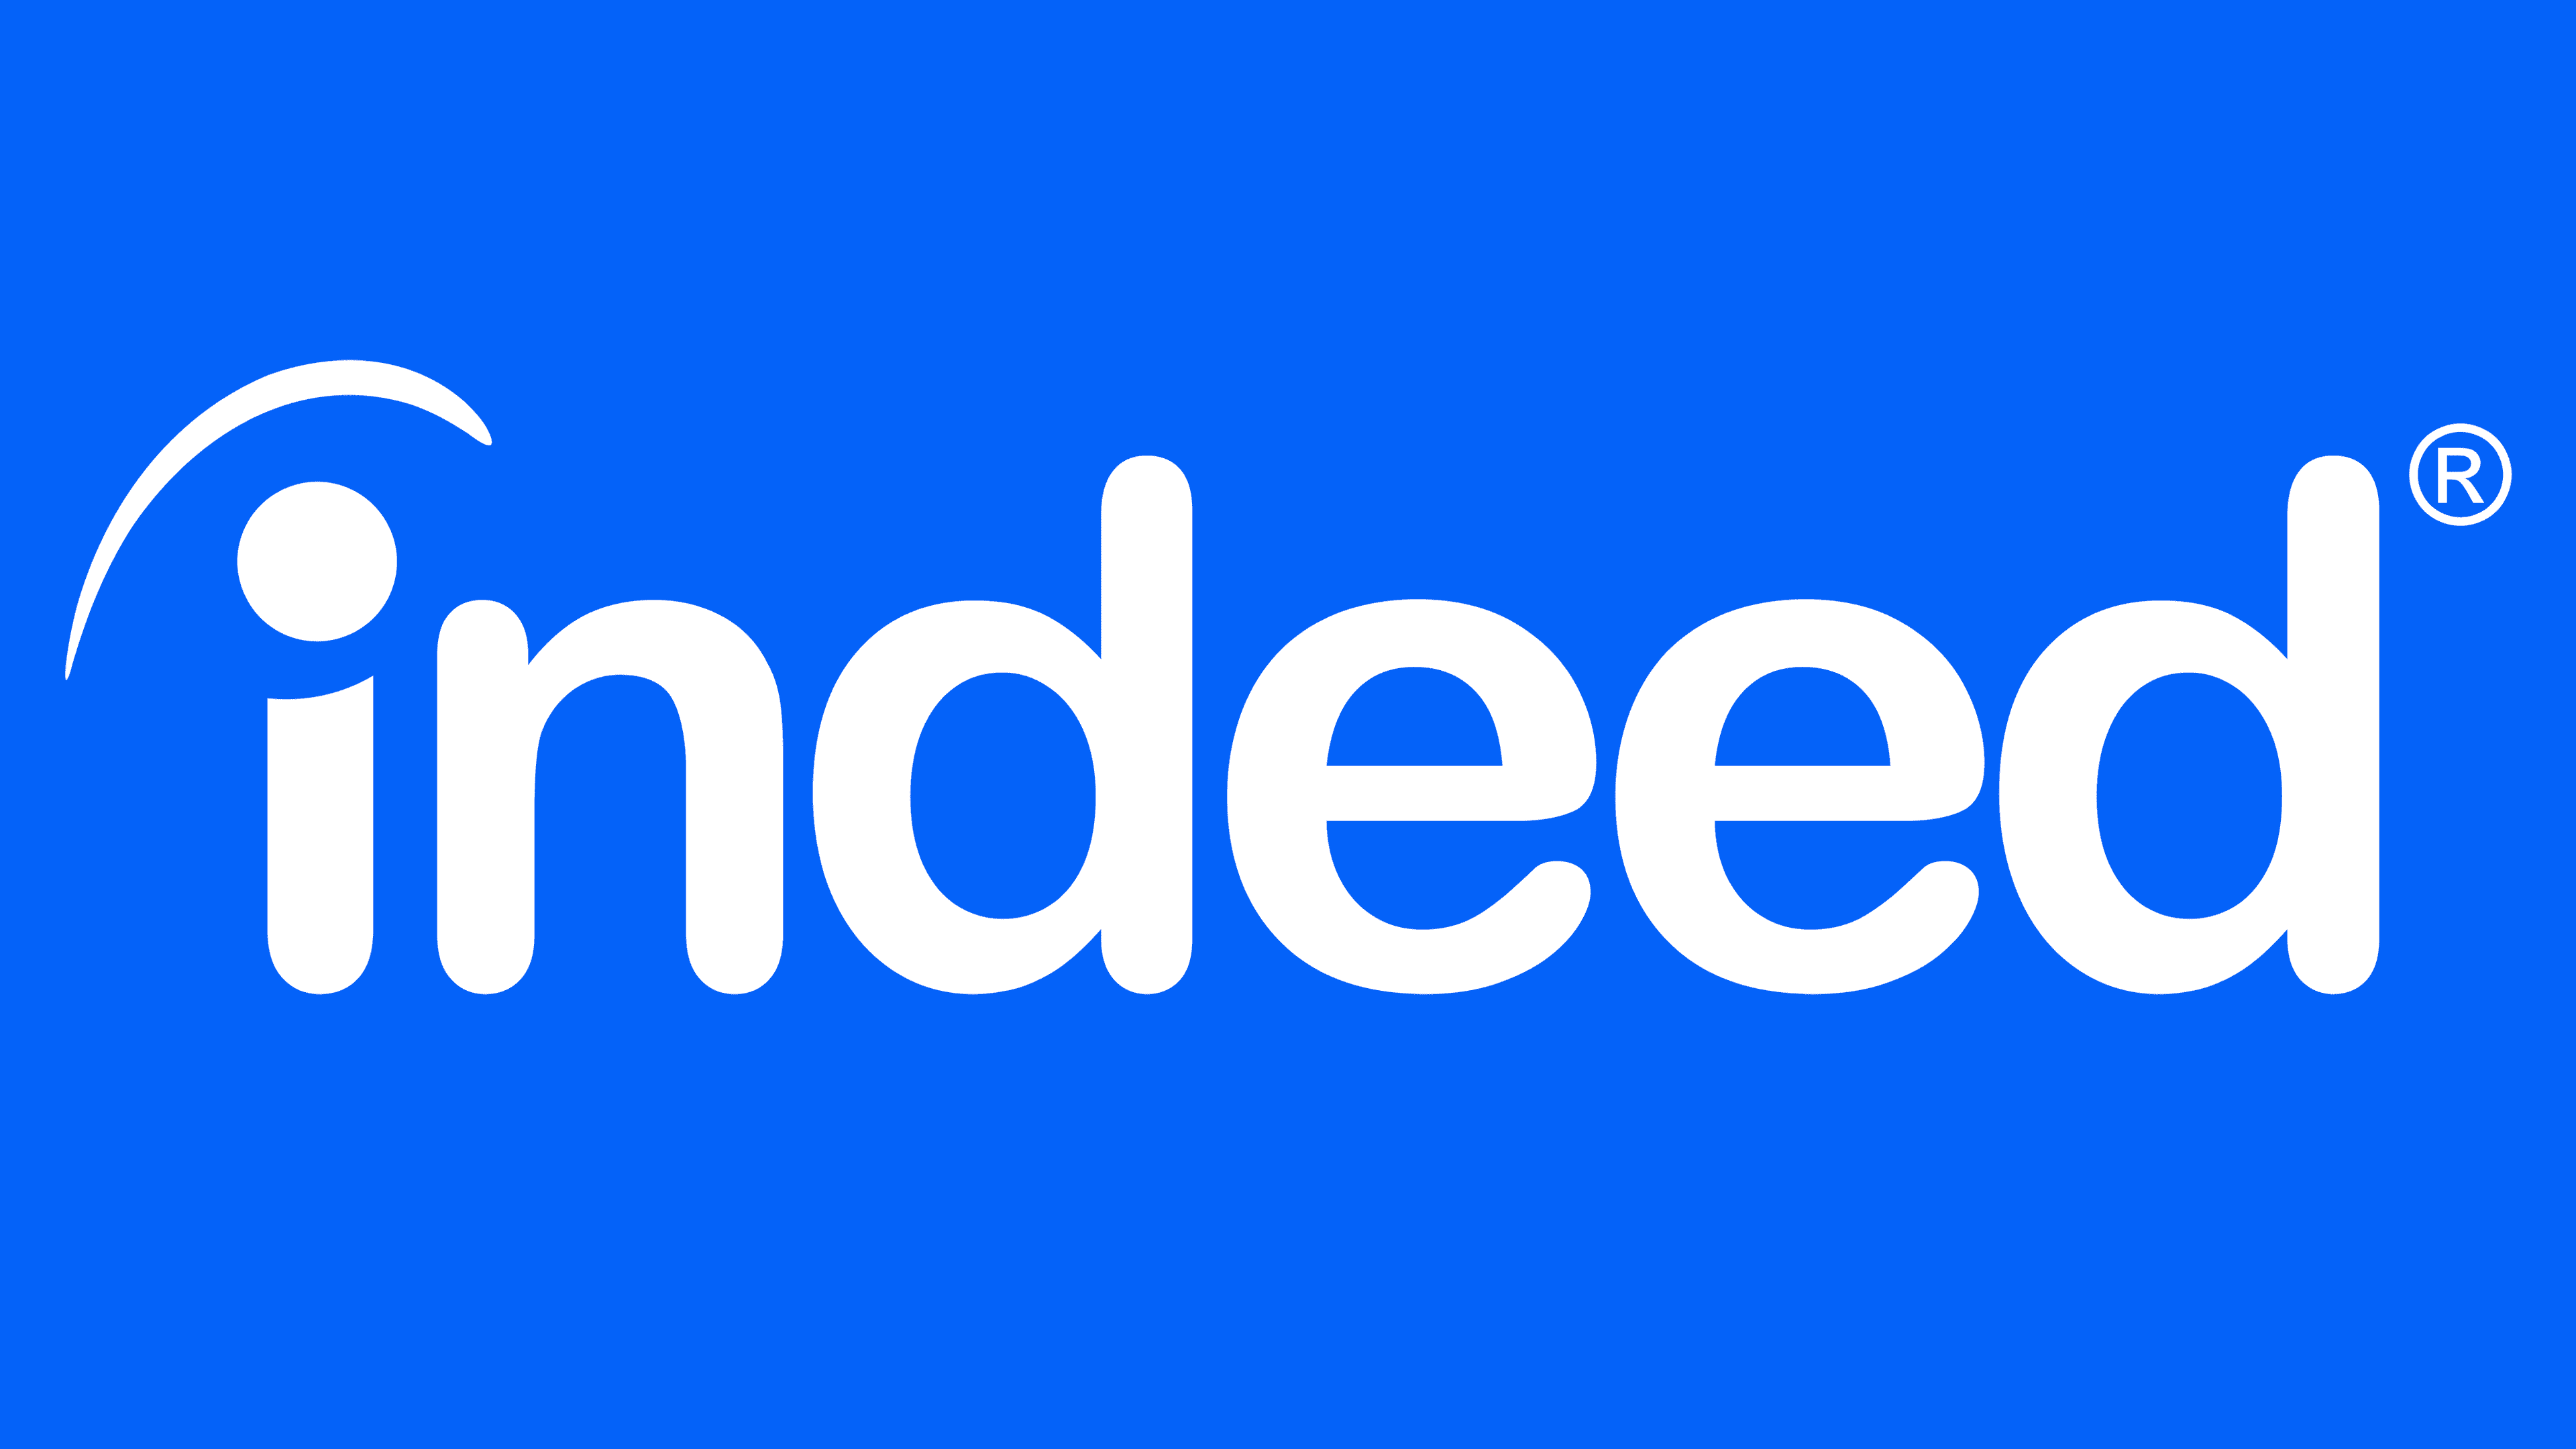

Indeed is one of the biggest websites for job listings and the highest-traffic job website in the United States. As soon-to-be graduates, we spend already quite some time on Indeed looking at jobs for after our Master's degree in Statistics and Data Science. Data Science related jobs are in demand and Indeed is full of them. With our analysis we want to have an insight into the Belgian job market for data related jobs. We want to find out what the demanded skills are and what topics appear in job descriptions.  We are especially interested in the job descriptions for listings appearing under different search terms. Is there a difference between jobs recommended when searching for Data Analyst, Data Scientist, Data Engineer, Machine Learning Engineer and Buisness Intelligence? Since Belgium is a multiligual mess, we are interested which job titles are most often posted in English. Finally, we want to find out if the job description is predictive for the search term under which a job appears.

The first step of the analysis is to scrape Indeed to aqurie the job descriptions. This poses several challenges as Indeed is not easy to scrape. Once we obtain the text from the scraping we prepare and clean it for our analysis. We will apply (WHAT TECHNIQUES)

# Imports

In the first step, we import the necessary packages for our anaylsis.

In [ ]:
#Installations
!pip install langdetect
!pip install fake-useragent
!pip install top2vec

#Basic packages
import pandas as pd
import re
import math
import time
import numpy as np

#Web scraping packages
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from langdetect import detect

#NLP packages
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

#Visualization
import seaborn as sns

#ML packages
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from top2vec import Top2Vec


# Web Scraping

The most difficult step of the analysis is to aquire the data. Since Indeed does not provide an API, we perform web scraping to get the job descriptions for different search terms. We used a trail and error strategy to find the right selector paths. We define functions to help us with the web scraping process: 

*   **get_number_of_iterations**: We inspect the structure of the URL to understand how to send our requests. The jop postings strech over multiple pages and we need to find out how many pages of postings to scan. We use BeautifulSoup to get the document as a nested data structure. We select the #searchCountPages in our soup to see how many postings there are in total, divide by the limit of postings displayed per page and round this value up.  Because we do not want get banned by the website, we use a random user agent for our requests.
*   **get_links**: Function to harvest the link to a job posting from the soup object.
*   **visible_texts**: Function to get the description text (body) from the soup and remove unnecessary whitespaces and the javascript code. 
*   **get_clean_text**: Create a BeautifulSoup object and apply the visible_texts function
*   **detect_language**: Detects the language a job posting is written in. For job postings in Belgium: English, French, Dutch or Unknown.
*   **sub_common_strings**: Every job description text starts and ends with the same senteces. This function removes these unnecessary senteces using regular expressions, since these senteces are irrelevant for our analysis.










In [ ]:
# Functions

def get_number_of_iterations(query, limit):
    URL = 'https://be.indeed.com/jobs?q=' + query +  '&l=belgium&limit=' + str(limit) + '&filter=' + str(0) + '&start=' + str(0)
    ua = UserAgent()
    header = {'User-Agent':str(ua.random)}
    webpage_request = requests.get(URL, headers = header)
    soup = BeautifulSoup(webpage_request.content, "html.parser")
    replaced_search_count = (soup.select('#searchCountPages')[0].text).replace('.', '')
    iterations = math.ceil(int(re.findall(r"\d+", replaced_search_count)[1])/limit)-1
    return iterations

def get_links(soup):
    links = []
    for link in soup.findAll('a'):
        if (len(re.findall(r"^/pagead/.*", str(link.get('href')))) + len(re.findall(r"^/rc/.*", str(link.get('href')))) > 0):
            links.append(link.get('href'))
    return links

def visible_texts(soup):
    re_spaces = re.compile(r'\s{3,}')
    text = ' '.join([s for s in soup.strings if s.parent.name not in ('style', 'script', 'head', 'title')])
    return re_spaces.sub(' ', text)

def get_clean_text(html):
    soup_temp = BeautifulSoup(html)
    visible_temp = visible_texts(soup_temp)
    return visible_temp
    
def detect_language(cleaned_text):
    lang = 'Unknown'
    try:
        lang = detect(cleaned_text)
    except:
        lang = 'Unknown'
    return lang
    
def sub_common_strings(cleaned_text):
    temp_cleaned_text = re.sub(r"^.*zoeken Geavanceerd zoeken ", "", cleaned_text)
    temp_cleaned_text = re.sub(r"Carrièregids Bladeren door vacatures.*$", "", temp_cleaned_text)
    return temp_cleaned_text

We decided to scrape the job postings for certain search terms. We were interested in the search results for "Business Intelligence", "Data Scientist", "Data Analyst", "Data Engineer" and "Machine Learning Engineer". Note that we were not able to scrape all search terms at once due to internet connection issues and requests coming back empty. We splitted the scraping, concatinated the dataframes and dropped duplicates.

In [ ]:
job_categories = ['business+intelligence', 'data+scientist', 'data+analyst', 'data+engineer', 'machine+learning+engineer']

Next, we gather the links to the job postings on Indeed. We use our user-agent and define the **indeed_job_frame** which will hold our data including links (Ad_Link) and search term (Job_Category). We set the limit of job postings per page to 50 (the maximum). We loop over the categories and number of pages for each categories. We keep track of the category and link by appending them to the meta_link_list and meta_category_list. To not overload the website and get banned, we us the sleep function with a 10s gap between every request.
The structure of the URL can be seen below. First hellooo


In [ ]:
filter_boolean = 0
limit = 50
ua = UserAgent()

indeed_job_frame = pd.DataFrame({'Job_Category': [], 'Ad_Link': []})

meta_category_list = []
meta_link_list = []

counter = 0
for category in job_categories:
    iterations = get_number_of_iterations(category, limit)
    for page in range(iterations):
        page_num = page*50
        URL = 'https://be.indeed.com/jobs?q=' + category +  '&l=belgium&limit=' + str(limit) + '&filter=' + str(filter_boolean) + '&start=' + str(page_num)
        header = {'User-Agent':str(ua.random)}
        webpage_request = requests.get(URL, headers = header)
        soup = BeautifulSoup(webpage_request.content, "html.parser")
        meta_link_list += get_links(soup)
        for count in range(len(get_links(soup))):
            meta_category_list.append(category)
        counter += 1
        print(category, iterations, counter)
        time.sleep(10)

We insert the meta_category_list and the meta_link_list as a columns to our indeed_job_frame and drop and duplicate rows. We see how many jobs posting links from which search term we harvested.

In [ ]:
indeed_job_frame['Job_Category'] = meta_category_list
indeed_job_frame['Ad_Link'] = meta_link_list
indeed_job_frame = indeed_job_frame.drop_duplicates()
indeed_job_frame.Job_Category.value_counts()

We use the gathered links to request the html data for each job posting. We append each request to the meta_html_list, which put as a column in out indeed_job_frame. We also include the sleep function with a 10s gap between the requets. This makes the process time consuming but we are not overwhelming the server with requests.

In [ ]:
Counter = 0
meta_html_list = []
for indeed_ad in indeed_job_frame.Ad_Link.tolist():
    URL = 'https://be.indeed.com' + str(indeed_ad)
    header = {'User-Agent':str(ua.random)}
    webpage_request = requests.get(URL, headers = header)
    meta_html_list.append(webpage_request.text)
    if (Counter % 100 == 0):
        print(Counter,'Jobs processed')
    Counter += 1
    time.sleep(10)
    
indeed_job_frame['HTML'] = meta_html_list

Here we apply the cleaning function on the HMTL column to extract the text and use the language detector to label the language a job posting is written in. We drop the HTML column from the data frame and save the results as a csv.

In [ ]:
#apply cleaning function
indeed_job_frame['Cleaned_Text'] = indeed_job_frame.HTML.apply(get_clean_text)    
#detect language of job descriptions
indeed_job_frame['Language'] = indeed_job_frame.Cleaned_Text.apply(detect_language)
#remove common strings
indeed_job_frame['Cleaned_Text'] = indeed_job_frame.Cleaned_Text.apply(sub_common_strings)
#drop the HTML column to get a lighter file
indeed_job_frame.drop('HTML',axis=1, inplace=True)
#save as csv for further analysis
indeed_job_frame.to_csv(r'/Users/ninamorgenstern/Desktop/jobs_indeed.csv', index = False)
indeed_job_frame